# FINN - End-to-End Flow
-----------------------------------------------------------------

In this notebook, we will take a simple, binarized, fully-connected network trained on the MNIST data set and take it all the way down to a customized bitfile running on a Zybo Z7-20 board. 

This notebook is quite lengthy, and some of the cells (involving Vivado synthesis) may take up to an hour to finish running. To let you save and resume your progress, we will save the intermediate ONNX models that are generated in the various steps to disk, so that you can jump back directly to where you left off.



## Overview

The FINN compiler comes with many *transformations* that modify the ONNX representation of the network according to certain patterns. This notebook demonstrates a sequence of such transformations to take a particular trained network all the way down to hardware, as shown in the figure below.

![](finn-design-flow-example.svg)

The white fields show the state of the network representation in the respective step. The colored fields represent the transformations that are applied to the network to achieve a certain result. The diagram is divided into 5 sections represented by a different color, each of it includes several flow steps. The flow starts in top left corner with Brevitas export (green section), followed by the preparation of the network (blue section) to bring the network into a form in which each layer can be represented by either a Vitis HLS function or a Verilog module. The model then gets passed to Vivado IPI stitching (orange section), and finally a PYNQ overlay bitfile is built and can be tested on a PYNQ board (yellow section).
There is an additional section for functional verification (red section) on the right side of the diagram, which we will not cover in this notebook. For details please take a look in the verification notebook which you can find [here](sfc_verification.ipynb)


This Jupyter notebook is organized based on the sections described above. We will use the following helper functions, `showSrc` to show source code of FINN library calls and `showInNetron` to show the ONNX model at the current transformation step. The Netron displays are interactive, but they only work when running the notebook actively and not on GitHub (i.e. if you are viewing this on GitHub you'll only see blank squares).

In [1]:
import os
import sys

from finn.util.visualization import showSrc, showInNetron
from finn.util.basic import make_build_dir

cwd = os.getcwd()
import_path = os.path.join(cwd, '../training')
import_path = os.path.abspath(import_path)
sys.path.append(import_path)
print("Import path: {0}".format(import_path))
    
build_dir = os.environ.get("FINN_BUILD_DIR", "./build")
##build_dir = "/home/kodachi77/project/finn/finn_dev_kodachi77"
#os.environ["FINN_BUILD_DIR"] = build_dir
print("Build dir: {0}".format(build_dir))

Import path: /home/kodachi77/project/finn/notebooks/training
Build dir: /tmp/finn_dev_kodachi77


## Outline
-------------
1. [Brevitas export](#brev_exp)
2. [Network preparation](#nw_prep)
3. [Hardware build](#vivado)
4. [PYNQ deployment](#hw_test)

## 1. Brevitas export <a id='brev_exp'></a>
FINN expects an ONNX model as input. This can be a model trained with [Brevitas](https://github.com/Xilinx/brevitas). Brevitas is a PyTorch library for quantization-aware training and the FINN Docker image comes with several [example Brevitas networks](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq). To show the FINN end-to-end flow, we'll use the TFC-w1a1 model as example network.

First a few things have to be imported. Then the model can be loaded with the pretrained weights.

In [2]:
import torch
import onnx

from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup

from models import fc

sfc = fc()

filename = os.path.join(import_path, 'checkpoints/sfc_1w1a.pth')
assert os.path.isfile(filename)
sfc.load_checkpoint(filename)

export_onnx_path = os.path.join(build_dir, "sfc_w1_a1.onnx")
export_qonnx(sfc, torch.randn(1, 1, 28, 28), os.path.join(build_dir, "sfc_w1_a1.onnx")); # semicolon added to suppress log
qonnx_cleanup(export_onnx_path, out_file=export_onnx_path)

/home/kodachi77/project/finn/notebooks/training/models.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  package = torch.load(checkpoint, map_location='cpu')


The model was now exported in QONNX format, loaded with the pretrained weights and saved under the name "tfc_w1_a1.onnx".
To visualize the exported model, Netron can be used. Netron is a visualizer for neural networks and allows interactive investigation of network properties. For example, you can click on the individual nodes and view the properties.

In [3]:
showInNetron(build_dir+"/sfc_w1_a1.onnx")

Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1.onnx' at http://0.0.0.0:8081


Now that we have the model in .onnx format, we can work with it using FINN. For that, `ModelWrapper` is used. It is a wrapper around the ONNX model which provides several helper functions to make it easier to work with the model. `ModelWrapper` is imported from the [QONNX repo](https://github.com/fastmachinelearning/qonnx), this repository contains several functionality that is used in FINN. The model was exported in QONNX format, to feed it into the FINN flow, our first step is to convert it to the FINN-ONNX format.

In [4]:
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
model = ModelWrapper(build_dir+"/sfc_w1_a1.onnx")
model = model.transform(ConvertQONNXtoFINN())

After the conversion we save the model and visualize it using Netron. As you can see, quantization is now expressed differently. Where we had Quant nodes before, there are now MultiThreshold nodes present in the graph.

In [5]:
model.save(build_dir+"/sfc_w1_a1_finn.onnx")
showInNetron(build_dir+"/sfc_w1_a1_finn.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_finn.onnx' at http://0.0.0.0:8081


Now the model is prepared and could be simulated using Python. How this works is described in the Jupyter notebook about verification and can be found [here](tfc_end2end_verification.ipynb#simpy).

The model can now also be processed in different ways. The principle of FINN are analysis and transformation passes, which can be applied to the model. An analysis pass extracts specific information about the model and returns it to the user in the form of a dictionary. A transformation pass changes the model and returns the changed model back to the FINN flow.

Since the goal in this notebook is to process the model to such an extent that a bitstream can be generated from it, the focus is on the transformations that are necessary for this. In the next section these are discussed in more detail.

## 2. Network preparation <a id='nw_prep'></a>

* [FINN-style Dataflow Architectures](#dataflow_arch)
* [Tidy-up transformations](#basic_trafo)
* [Streamlining](#streamline)
* [Conversion to HW layers](#hw_layers)
* [Creating a Dataflow Partition](#dataflow_partition)
* [Specialize layers](#specialize_layers)
* [Folding and Datawidth Converter, FIFO and TLastMarker Insertion](#folding)


In this section, we will put the network through a series of transformations that puts it in a form that can be stitched together to form a FINN-style dataflow architecture, yielding a high-performance, high-efficiency FPGA accelerator.

### FINN-style Dataflow Architectures <a id='dataflow_arch'></a>

We start with a quick recap of FINN-style dataflow architectures. The key idea in such architectures is to parallelize across layers as well as within layers by dedicating a proportionate amount of compute resources to each layer, as illustrated in the figure below taken from the [FINN-R paper](https://arxiv.org/pdf/1809.04570.pdf):

![](finn-hw-arch.png)

In practice, the compute arrays are instantiated by function calls to optimized Vitis HLS building blocks from the [finn-hlslib](https://github.com/Xilinx/finn-hlslib) library or by Verilog modules from the [finn-rtllib](https://github.com/Xilinx/finn/tree/main/finn-rtllib). As these function calls/modules can only handle certain patterns/cases, we need to transform the network into an appropriate form so that we can replace network layers with these function calls/modules, which is the goal of the network preparation process.

### Tidy-up transformations <a id='basic_trafo'></a>
This section deals with some basic transformations, which are applied to the model like a kind of "tidy-up" to make it easier to be processed. They do not appear in the diagram above, but they are applied in many steps in the FINN flow to postprocess the model after a transformation and/or to prepare it for the next transformation.

These transformations are:
* GiveUniqueNodeNames
* GiveReadableTensorNames
* InferShapes
* InferDataTypes
* FoldConstants
* RemoveStaticGraphInputs

In the first two transformations (`GiveUniqueNodeNames`, `GiveReadableTensorNames`) the nodes in the graph are first given unique (by enumeration) names, then the tensors are given human-readable names (based on the node names). The following two transformations (`InferShapes`, `InferDataTypes`) derive the shapes and data types of the tensors from the model properties and set them in the `ValueInfo` of the model. These transformations can almost always be applied without negative effects and do not affect the structure of the graph, ensuring that all the information needed is available.

The next listed transformation is `FoldConstants`, which performs constant folding. It identifies a node with constant inputs and determines its output. The result is then set as constant-only inputs for the following node and the old node is removed. Although this transformation changes the structure of the model, it is a transformation that is usually always desired and can be applied to any model. And finally, we have `RemoveStaticGraphInputs` to remove any top-level graph inputs that already have ONNX initializers associated with them. 

These transformations can be imported and applied as follows.

In [6]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants

model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save(build_dir+"/sfc_w1_a1_tidy.onnx")

The result of these transformations can be viewed with netron after the model has been saved again. By clicking on the individual nodes, it can now be seen, for example, that each node has been given a name. Also the whole upper area could be folded, so that now the first node is "Reshape".

In [7]:
showInNetron(build_dir+"/sfc_w1_a1_tidy.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_tidy.onnx' at http://0.0.0.0:8081


### Adding Pre- and Postprocessing <a id='prepost'></a>

In many cases, it's common to apply some preprocessing to the raw data in a machine learning framework prior to training. For image classification networks, this may include conversion of raw 8-bit RGB values into floating point values between 0 and 1. Similarly, at the output of the network some postprocessing may be performed during deployment, such as extracting the indices of the classifications with the largest value (top-K indices).

In FINN, we can bake some of these pre/postprocessing operatings into the graph, and in some cases these can be highly beneficial for performance by allowing our accelerator to directly consume raw data instead of going through CPU preprocessing. 

We'll demonstrate this for our small image classification network as follows. Brevitas preprocesses BNN-PYNQ network inputs with `torchvision.transforms.ToTensor()` [prior to training](https://github.com/Xilinx/brevitas/blob/master/src/brevitas_examples/bnn_pynq/trainer.py#L93), which converts 8-bit RGB values into floats between 0 and 1 by dividing the input by 255. We can achieve the same effect in FINN by exporting a single-node ONNX graph for division by 255 (which already exists as `finn.util.pytorch.ToTensor` and merging this with our original model. Finally, we're going to mark our input tensor as 8-bit to let FINN know which level of precision to use.

In [8]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType

model = ModelWrapper(build_dir+"/sfc_w1_a1_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+"/sfc_w1_a1_preproc.onnx"
export_qonnx(totensor_pyt, torch.randn(ishape), chkpt_preproc_name)
qonnx_cleanup(chkpt_preproc_name, out_file=chkpt_preproc_name)
pre_model = ModelWrapper(chkpt_preproc_name)
pre_model = pre_model.transform(ConvertQONNXtoFINN())

# join preprocessing and core model
model = model.transform(MergeONNXModels(pre_model))
# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])

model.save(build_dir+"/sfc_w1_a1_with_preproc.onnx")
showInNetron(build_dir+"/sfc_w1_a1_with_preproc.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_with_preproc.onnx' at http://0.0.0.0:8081


/home/kodachi77/project/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:127: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


You can observe two changes in the graph above: a `Div` node has appeared in the beginning to perform the input preprocessing, and the `global_in` tensor now has a quantization annotation to mark it as an unsigned 8-bit value.

For the postprocessing we'll insert a TopK node for k=1 at the end of our graph. This will extract the index (class number) for the largest-valued output.

In [9]:
from qonnx.transformation.insert_topk import InsertTopK

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+"/sfc_w1_a1_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(build_dir+"/sfc_w1_a1_pre_post.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_pre_post.onnx' at http://0.0.0.0:8081


Notice the`TopK` node that has appeared at the end of the network. With our pre- and postprocessing in place, we can move on to the next step in the flow, which is streamlining.

### Streamlining <a id='streamline'></a>
Streamlining is a transformation containing several sub-transformations. The goal of streamlining is to eliminate floating point operations by moving them around, then collapsing them into one operation and in the last step transform them into multi-thresholding nodes. For more information on the theoretical background of this, see [this paper](https://arxiv.org/pdf/1709.04060).

Let's have a look at which sub-transformations `Streamline` consists of:

In [10]:
from finn.transformation.streamline import Streamline
showSrc(Streamline)

class Streamline(Transformation):
    """Apply the streamlining transform, see arXiv:1709.04060."""

    def apply(self, model):
        streamline_transformations = [
            ConvertSubToAdd(),
            ConvertDivToMul(),
            BatchNormToAffine(),
            ConvertSignToThres(),
            MoveMulPastMaxPool(),
            MoveScalarLinearPastInvariants(),
            AbsorbSignBiasIntoMultiThreshold(),
            MoveAddPastMul(),
            MoveScalarAddPastMatMul(),
            MoveAddPastConv(),
            MoveScalarMulPastMatMul(),
            MoveScalarMulPastConv(),
            MoveAddPastMul(),
            CollapseRepeatedAdd(),
            CollapseRepeatedMul(),
            MoveMulPastMaxPool(),
            AbsorbAddIntoMultiThreshold(),
            FactorOutMulSignMagnitude(),
            AbsorbMulIntoMultiThreshold(),
            Absorb1BitMulIntoMatMul(),
            Absorb1BitMulIntoConv(),
            RoundAndClipThresholds(),
        ]
        for tr

As can be seen, several transformations are involved in the streamlining transformation. There are move and collapse transformations. In the last step the operations are transformed into multithresholds. The involved transformations can be viewed in detail [here](https://github.com/Xilinx/finn/tree/main/src/finn/transformation/streamline). After each transformation, three of the tidy-up transformations (`GiveUniqueNodeNames`, `GiveReadableTensorNames` and `InferDataTypes`) are applied to the model.

After streamlining the network looks as follows:

In [11]:
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper(build_dir+"/sfc_w1_a1_pre_post.onnx")
# move initial Mul (from preproc) past the Reshape
model = model.transform(MoveScalarLinearPastInvariants())
# streamline
model = model.transform(Streamline())
model.save(build_dir+"/sfc_w1_a1_streamlined.onnx")
showInNetron(build_dir+"/sfc_w1_a1_streamlined.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_streamlined.onnx' at http://0.0.0.0:8081


You can see that the network has become simplified considerably compared to the previous step -- a lot of nodes have disappeared between the `MatMul` layers. 

**The current implementation of streamlining is highly network-specific and may not work for your network if its topology is very different than the example network here. We hope to rectify this in future releases.**

Our example network is a quantized network with 1-bit bipolar (-1, +1 values) precision, and we want FINN to implement them as XNOR-popcount operations [as described in the original FINN paper](https://arxiv.org/pdf/1612.07119). For this reason, after streamlining, the resulting bipolar matrix multiplications are converted into xnorpopcount operations. This transformation produces operations that are again collapsed and converted into thresholds. This procedure is shown below. 

In [12]:
from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(absorb.AbsorbAddIntoMultiThreshold())
model = model.transform(absorb.AbsorbMulIntoMultiThreshold())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model.save(build_dir+"/sfc_w1a1_ready_for_hw_conversion.onnx")
showInNetron(build_dir+"/sfc_w1a1_ready_for_hw_conversion.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1a1_ready_for_hw_conversion.onnx' at http://0.0.0.0:8081


Observe the pairs of `XnorPopcountmatMul` and `MultiThreshold` layers following each other -- this is the particular pattern that the next step will be looking for in order to convert them to hardware (HW) layers.

### Conversion to HW layers <a id='hw_layers'></a>
Converts the nodes to HW layers, these layers are abstraction layers that do not directly correspond to an HLS or Verilog implementation but they will be converted in either one later in the flow. In our case this transformation converts pairs of binary XnorPopcountMatMul layers to MVAU layers (matrix vector activation unit). Any immediately following MultiThreshold layers will also be absorbed into the MVAU.

Below is the code for the transformation and the network is visualized using netron to create the new structure with `MVAU` nodes.

In [13]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
model = ModelWrapper(build_dir+"/sfc_w1a1_ready_for_hw_conversion.onnx")
model = model.transform(to_hw.InferBinaryMatrixVectorActivation())
# TopK to LabelSelect
model = model.transform(to_hw.InferLabelSelectLayer())
# input quantization (if any) to standalone thresholding
model = model.transform(to_hw.InferThresholdingLayer())
model.save(build_dir+"/sfc_w1_a1_hw_layers.onnx")
showInNetron(build_dir+"/sfc_w1_a1_hw_layers.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_hw_layers.onnx' at http://0.0.0.0:8081


### Creating a Dataflow Partition <a id='dataflow_partition'></a>

In the graph above, you can see that there is a mixture of FINN HW layers (`MVAU` and `Thresholding`) with one regular ONNX layers (Reshape). To create a bitstream, FINN needs a model with only HW layers. In order to achieve this, we will use the `CreateDataflowPartition` transformation to create a "dataflow partition" in this graph, separating out the HLS layers into another model, and replacing them with a placeholder layer called StreamingDataflowPartition.

In [14]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper(build_dir+"/sfc_w1_a1_hw_layers.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir+"/sfc_w1_a1_dataflow_parent.onnx")
showInNetron(build_dir+"/sfc_w1_a1_dataflow_parent.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_dataflow_parent.onnx' at http://0.0.0.0:8081


We can see that the `MVAU` instances and the `Thresholding` in the beginning have all been replaced with a single `StreamingDataflowPartition`, which has an attribute `model` that points to the extracted, HW dataflow-only graph:

In [15]:
from qonnx.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/dataflow_partition_5c2xgygu/partition_0.onnx' at http://0.0.0.0:8081


We can see all the extracted `MVAU` instances and the `Thresholding` have been moved to the child (dataflow) model. We will load the child model with `ModelWrapper` and continue working on it.

In [16]:
model = ModelWrapper(dataflow_model_filename)

### Specialize layers <a id='specialize_layers'></a>

The network is converted to HW abstraction layers and we have excluded the non-HW layers to continue with the processing of the model. HW abstraction layers are abstract (placeholder) layers that can be either implemented in HLS or as an RTL module using FINN. In the next flow step, we convert each of these layers to either an HLS or RTL variant by calling the `SpecializeLayers` transformation. It is possible to let the FINN flow know a preference for the implementation style `{"hls", "rtl"}` and depending on the layer type this wish will be fulfilled or it will be set to a reasonable default. In the tfc example, we will set all layers to their HLS variants. To showcase how to set the preferred implementation, we will set the node attribute in the `Thresholding` layer to `"hls"`, for the `MVAUs` and the `LabelSelect` we will leave this node attribute empty and in this case by default it will be set to HLS.

In [17]:
thresh_node = model.get_nodes_by_op_type("Thresholding")[0]
thresh_node_inst = getCustomOp(thresh_node)
thresh_node_inst.set_nodeattr("preferred_impl_style", "hls")

We'll define two helper variables that describe the Xilinx FPGA part name and the PYNQ board name that we are targeting.

In [18]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

dict_keys(['Ultra96', 'Ultra96-V2', 'Pynq-Z1', 'Pynq-Z2', 'Zybo-z7-20', 'ZCU102', 'ZCU104', 'ZCU111', 'RFSoC2x2', 'RFSoC4x2', 'KV260_SOM'])


In [19]:
# change this if you have a different PYNQ board, see list above
pynq_board = "Zybo-z7-20"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 10

Then we will call `SpecializeLayers` to convert each HW abstraction layer to (in this case) an HLS variant.

In [20]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
model = model.transform(SpecializeLayers(fpga_part))

model.save(build_dir+"/sfc_w1_a1_specialize_layers.onnx")
showInNetron(build_dir+"/sfc_w1_a1_specialize_layers.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_specialize_layers.onnx' at http://0.0.0.0:8081


Each node type has now a suffix (`_hls`) and the module (`
finn.custom_op.fpgadataflow.hls` also indicates that that the HLS variant of the layer is selected.
We can now proceed by adjusting the parallelism of each node to customize the performance and resource usage.)

### Folding: Adjusting the Parallelism <a id='folding'></a>

*Folding* in FINN describes how much a layer is time-multiplexed in terms of execution resources. There are several *folding factors* for each layer, controlled by the PE (parallelization over outputs) and SIMD (parallelization over inputs) parameters as described by the original [FINN paper](https://arxiv.org/pdf/1612.07119). The higher the PE and SIMD values are set, the faster the generated accelerator will run, and the more FPGA resources it will consume. 

Each MVAU_hls node has two attributes that specify the degree of folding, PE and SIMD. In all nodes the values for these attributes are set as default to 1, which would correspond to a maximum folding (time multiplexing) and thus minimum performance. 

Since the folding parameters are node attributes, they can be easily accessed and changed using a helper function of the `ModelWrapper`. But first we take a closer look at one of the nodes that implement a Matrix-Vector-Activation operation. This is where the Netron visualization helps us, in the above diagram we can see that the model contains four `MVAUs`. So as an example we extract the second node of the graph.

We can use the higher-level CustomOp wrappers for this node. These wrappers provide easy access to specific properties of these nodes, such as the folding factors (PE and SIMD). Above, we have already used this abstraction to set the node attribute of the Thresholding HW layer.
Let's have a look at which node attributes are defined by the CustomOp wrapper, and adjust the SIMD and PE attributes.

In [21]:
fc0 = model.graph.node[1]
fc0w = getCustomOp(fc0)

print("CustomOp wrapper is of class " + fc0w.__class__.__name__)

fc0w.get_nodeattr_types()

CustomOp wrapper is of class MVAU_hls


{'PE': ('i', True, 0),
 'SIMD': ('i', True, 0),
 'MW': ('i', True, 0),
 'MH': ('i', True, 0),
 'resType': ('s', False, 'auto', {'auto', 'dsp', 'lut'}),
 'ActVal': ('i', False, 0),
 'inputDataType': ('s', True, ''),
 'weightDataType': ('s', True, ''),
 'outputDataType': ('s', True, ''),
 'accDataType': ('s', False, 'INT32'),
 'binaryXnorMode': ('i', False, 0, {0, 1}),
 'noActivation': ('i', False, 0, {0, 1}),
 'numInputVectors': ('ints', False, [1]),
 'mem_mode': ('s',
  False,
  'internal_decoupled',
  {'external', 'internal_decoupled', 'internal_embedded'}),
 'ram_style': ('s', False, 'auto', {'auto', 'block', 'distributed', 'ultra'}),
 'ram_style_thresholds': ('s',
  False,
  'auto',
  {'auto', 'block', 'distributed'}),
 'runtime_writeable_weights': ('i', False, 0, {0, 1}),
 'backend': ('s', True, 'fpgadataflow'),
 'preferred_impl_style': ('s', False, '', {'', 'hls', 'rtl'}),
 'code_gen_dir_ipgen': ('s', False, ''),
 'ipgen_path': ('s', False, ''),
 'ip_path': ('s', False, ''),
 'ip_

We can see that the PE and SIMD are listed as node attributes, as well as the depths of the FIFOs that will be inserted between consecutive layers, and all can be adjusted using `set_nodeattr` subject to certain constraints. There are also a lot of additional attributes that can be set for this node type.
**In this notebook we are setting the folding factors and FIFO depths manually but it is possible to use FINN transformations for this ([SetFolding](https://github.com/Xilinx/finn/blob/main/src/finn/transformation/fpgadataflow/set_folding.py) and [InsertAndSetFIFODepths](https://github.com/Xilinx/finn/blob/main/src/finn/transformation/fpgadataflow/set_fifo_depths.py)).**

In [22]:
fc_layers = model.get_nodes_by_op_type("MVAU_hls")
# (PE, SIMD, in_fifo_depth, out_fifo_depth, ramstyle) for each layer
config = [
    (16, 49, [16], [64], "block"),
    (16, 16, [64], [64], "auto"),
    (16, 16, [64], [64], "auto"),
    (10, 8, [64], [10], "distributed"),
]
for fcl, (pe, simd, ififo, ofifo, ramstyle) in zip(fc_layers, config):
    fcl_inst = getCustomOp(fcl)
    fcl_inst.set_nodeattr("PE", pe)
    fcl_inst.set_nodeattr("SIMD", simd)
    fcl_inst.set_nodeattr("inFIFODepths", ififo)
    fcl_inst.set_nodeattr("outFIFODepths", ofifo)
    fcl_inst.set_nodeattr("ram_style", ramstyle)
    
# set parallelism for input quantizer to be same as first layer's SIMD
inp_qnt_node = model.get_nodes_by_op_type("Thresholding_hls")[0]
inp_qnt = getCustomOp(inp_qnt_node)
inp_qnt.set_nodeattr("PE", 49)

We are setting PE and SIMD so that each layer has a total folding of 16.

Besides PE and SIMD three other node attributes are set. `ram_style` specifies how the weights are to be stored (BRAM, LUTRAM, and so on). It can be selected explicitly or with the option `auto` you can let Vivado decide.
`inFIFODepths` and `outFIFODepths` specifies the FIFO depths that is needed by the node from the surrounding FIFOs. These attributes are used in the transformation 'InsertFIFO' to insert the appropriate FIFOs between the nodes, which will be automatically called as part of the hardware build process.

In previous versions of FINN we had to call transformations to insert data width converters, FIFOs and `TLastMarker` manually at this step. This is no longer needed, as all this is taken care of by the `ZynqBuild` or `VitisBuild` transformations.

In [23]:
model.save(build_dir+"/sfc_w1_a1_set_folding_factors.onnx")
showInNetron(build_dir+"/sfc_w1_a1_set_folding_factors.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_set_folding_factors.onnx' at http://0.0.0.0:8081


This completes the network preparation and the network can be passed on to the next block *Vitis HLS and IPI*, which is described below.

## 3. Hardware Build <a id='vivado'></a>

We're finally ready to start generating hardware from our network. Depending on whether you want to target a Zynq or Alveo platform, FINN offers two transformations to build the accelerator, integrate into an appropriate shell and build a bitfile. These are `ZynqBuild` and `VitisBuild` for Zynq and Alveo, respectively. In this notebook we'll demonstrate the `ZynqBuild` as these boards are more common and it's much faster to complete bitfile generation for the smaller FPGAs found on them.

In previous versions of FINN, we had to manually go through several steps to generate HLS/RTL code, stitch IP, create a PYNQ project and run synthesis. All these steps are now performed by the `ZynqBuild` transform (or the `VitisBuild` transform for Alveo). **As this involves calling HLS synthesis and Vivado synthesis, this transformation will run for some time (up to half an hour depending on your PC).**

In [24]:
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild
model = ModelWrapper(build_dir+"/sfc_w1_a1_set_folding_factors.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns))

/home/kodachi77/project/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 10 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
/home/kodachi77/project/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:234: UserWarning: Input FIFO for IODMA_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/kodachi77/project/finn/src/finn/transformation/fpgadataflow/insert_fifo.py:294: UserWarning: Output FIFO for LabelSelect_hls_0_out0 has depth 2 and won't
                        be created. This may cause RTL simulation issues.
                        
  warnings.warn(
/home/kodachi77/project/finn/src/finn/transformation/fpgadataflow/create_stitched_ip.py:290: UserWarning: First node is not StreamingFIFO or IODMA.
                You may experience incorrect stitched-IP rtlsim or hardware
                behavior. It is strongly recommen

After the `ZynqBuild` we run one additional transformation to generate a PYNQ driver for the accelerator.

In [25]:
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
model = model.transform(MakePYNQDriver("zynq-iodma"))

In [26]:
model.save(build_dir + "/sfc_w1_a1_post_synthesis.onnx")

### Examining the generated outputs <a id='gen_outputs'></a>

Let's start by viewing the post-synthesis model in Netron:

In [27]:
showInNetron(build_dir + "/sfc_w1_a1_post_synthesis.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/sfc_w1_a1_post_synthesis.onnx' at http://0.0.0.0:8081


We can see that our sequence of HLS layers has been replaced with `StreamingDataflowPartition`s, each of which point to a different ONNX file. You can open a Netron session for each of them to view their contents. Here, the first and last partitions contain only an `IODMA` node, which was inserted automatically to move data between DRAM and the accelerator. Let's take a closer look at the middle partition, which contains all our layers:

In [28]:
model = ModelWrapper(build_dir + "/sfc_w1_a1_post_synthesis.onnx")
sdp_node_middle = getCustomOp(model.graph.node[1])
postsynth_layers = sdp_node_middle.get_nodeattr("model")

showInNetron(postsynth_layers)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_kodachi77/dataflow_partition_ng5f7il0/partition_2.onnx' at http://0.0.0.0:8081


We can see that `StreamingFIFO` and `StreamingDataWidthConverter` instances have been automatically inserted into the graph prior to hardware build. Both layer types are inserted as RTL variants. Transformations like `ZynqBuild` use the `metadata_props` of the model to put in additional metadata information relevant to the results of the transformation. Let's examine the metadata for the current graph containing all layers:

In [29]:
model = ModelWrapper(postsynth_layers)
model.model.metadata_props

[key: "floorplan_json"
value: "/tmp/finn_dev_kodachi77/vitis_floorplan_jl1qdhed/floorplan.json"
, key: "vivado_stitch_proj"
value: "/tmp/finn_dev_kodachi77/vivado_stitch_proj_ncnyhi3r"
, key: "clk_ns"
value: "10"
, key: "wrapper_filename"
value: "/tmp/finn_dev_kodachi77/vivado_stitch_proj_ncnyhi3r/finn_vivado_stitch_proj.gen/sources_1/bd/StreamingDataflowPartition_1/hdl/StreamingDataflowPartition_1_wrapper.v"
, key: "vivado_stitch_vlnv"
value: "xilinx_finn:finn:StreamingDataflowPartition_1:1.0"
, key: "vivado_stitch_ifnames"
value: "{\"clk\": [\"ap_clk\"], \"rst\": [\"ap_rst_n\"], \"s_axis\": [[\"s_axis_0\", 392]], \"m_axis\": [[\"m_axis_0\", 8]], \"aximm\": [], \"axilite\": []}"
, key: "platform"
value: "zynq-iodma"
]

Here we see that a Vivado project was built to create what we call the `stitched IP`, where all the IP blocks implementing various layers will be stitched together. You can view this stitched block design in Vivado, or [here](StreamingDataflowPartition_1.pdf) as an exported PDF.

Moving back to the top-level model, recall that `ZynqBuild` will create a Vivado project and synthesize it, so it will be creating metadata entries related to the paths and files that were created:

In [30]:
model = ModelWrapper(build_dir + "/sfc_w1_a1_post_synthesis.onnx")
model.model.metadata_props

[key: "floorplan_json"
value: "/tmp/finn_dev_kodachi77/vitis_floorplan_jl1qdhed/floorplan.json"
, key: "vivado_pynq_proj"
value: "/tmp/finn_dev_kodachi77/vivado_zynq_proj_9nli3r_p"
, key: "bitfile"
value: "/tmp/finn_dev_kodachi77/vivado_zynq_proj_9nli3r_p/resizer.bit"
, key: "hw_handoff"
value: "/tmp/finn_dev_kodachi77/vivado_zynq_proj_9nli3r_p/resizer.hwh"
, key: "vivado_synth_rpt"
value: "/tmp/finn_dev_kodachi77/vivado_zynq_proj_9nli3r_p/synth_report.xml"
, key: "platform"
value: "zynq-iodma"
, key: "pynq_driver_dir"
value: "/tmp/finn_dev_kodachi77/pynq_driver_3x8k91hw"
]

Here, we can see the directories that were created for the PYNQ driver (`pynq_driver_dir`) and the Vivado synthesis project (`vivado_pynq_proj`), as well as the locations of the bitfile, hardware handoff file and synthesis report.     

In [31]:
! ls {model.get_metadata_prop("vivado_pynq_proj")}

finn_zynq_link.cache	      finn_zynq_link.runs  resizer.bit	     vivado.jou
finn_zynq_link.gen	      finn_zynq_link.srcs  resizer.hwh	     vivado.log
finn_zynq_link.hw	      finn_zynq_link.xpr   synth_project.sh
finn_zynq_link.ip_user_files  ip_config.tcl	   synth_report.xml


Feel free to examine the generated Vivado project to get a feel for how the system-level integration is performed for the  FINN-generated "stitched IP", which appears as `StreamingDataflowPartition_1` in the top-level block design -- you can see it as a block diagram exported to PDF [here](top.pdf).


## 4.  PYNQ deployment <a id='hw_test'></a>

* [Deployment](#deploy)
* [Validation on PYNQ Board](#validation)
* [Throughput Test on PYNQ Board](#throughput)


The bitfile and generated driver will be copied together with some necessary files for execution into a deployment folder which then can be used to run the network on the PYNQ board.

### Deployment <a id='deploy'></a>

We'll now create a deployment folder with the bitfile and driver file(s), we zip it and afterwards it can be copied to the PYNQ board for execution and validation.

In [32]:
from shutil import copy
from distutils.dir_util import copy_tree

# create directory for deployment files
deployment_dir = make_build_dir(prefix="pynq_deployment_")
model.set_metadata_prop("pynq_deployment_dir", deployment_dir)

# get and copy necessary files
# .bit and .hwh file
bitfile = model.get_metadata_prop("bitfile")
hwh_file = model.get_metadata_prop("hw_handoff")
deploy_files = [bitfile, hwh_file]

for dfile in deploy_files:
    if dfile is not None:
        copy(dfile, deployment_dir)

# driver.py and python libraries
pynq_driver_dir = model.get_metadata_prop("pynq_driver_dir")
copy_tree(pynq_driver_dir, deployment_dir)

['/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/driver_base.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/finn/util/__init__.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/finn/util/data_packing.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/driver.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/qonnx/core/datatype.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/qonnx/core/__init__.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/qonnx/util/__init__.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/qonnx/util/basic.py',
 '/tmp/finn_dev_kodachi77/pynq_deployment_leutct02/validate.py']

Next to these files, we will also need an example numpy array to test the network on the PYNQ board. You may recall that one "reshape" node was left out of the StreamingDataflowPartition. We'll do that manually with a numpy function call when passing in the input, but everything else in the network ended up inside the StreamingDataflowPartition so that's all we need to do. The example numpy array can then be saved as .npy file. 

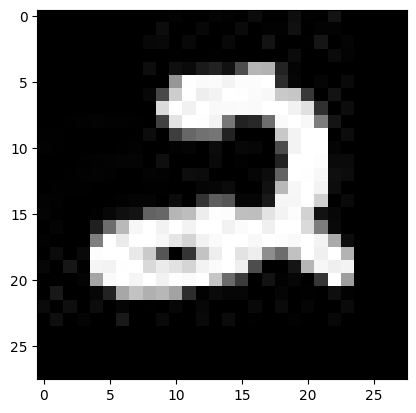

In [33]:
from pkgutil import get_data
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt

raw_i = get_data("qonnx.data", "onnx/mnist-conv/test_data_set_0/input_0.pb")
x = nph.to_array(onnx.load_tensor_from_string(raw_i))
plt.imshow(x.reshape(28,28), cmap='gray')

In [34]:
import numpy as np

model = ModelWrapper(build_dir + "/sfc_w1_a1_post_synthesis.onnx")
iname = model.graph.input[0].name
oname = parent_model.graph.output[0].name
ishape = model.get_tensor_shape(iname)
print("Expected network input shape is " + str(ishape))
np.save(deployment_dir + "/input.npy", x.reshape(ishape))

Expected network input shape is [1, 784]


In [35]:
! ls {deployment_dir}

driver_base.py	finn	   qonnx	resizer.hwh	 validate.py
driver.py	input.npy  resizer.bit	runtime_weights


In [36]:
from shutil import make_archive
make_archive('deploy-on-pynq-sfc', 'zip', deployment_dir)

'/home/kodachi77/project/finn/notebooks/notebooks/deploy-on-pynq-sfc.zip'

You can now download the created zipfile (**File -> Open**, mark the checkbox next to the `deploy-on-pynq-sfc.zip` and select Download from the toolbar), then copy it to your PYNQ board (for instance via `scp` or `rsync`). Then, run the following commands **on the PYNQ board** to extract the archive and run the execution:

```shell
unzip deploy-on-pynq-sfc.zip -d finn-sfc-demo
cd finn-sfc-demo
sudo python3 -m pip install bitstring
sudo python3 driver.py --exec_mode=execute --batchsize=1 --bitfile=resizer.bit --inputfile=input.npy
```

The output will be saved on the PYNQ board as `output.npy` and can be copied to the host and opened with `np.load()`.

### Validating the Accuracy on a PYNQ Board <a id='validation'></a>

**Ensure that your PYNQ board has a working internet connecting for the next steps, since there is some downloading involved.**

To validate the accuracy, we first need to install the [`dataset-loading`](https://github.com/fbcotter/dataset_loading) Python package to the PYNQ board. This will give us a convenient way of downloading and accessing the MNIST dataset.


Command to execute on PYNQ board:

```shell
sudo pip3 install git+https://github.com/fbcotter/dataset_loading.git@0.0.4#egg=dataset_loading
```

We can now use the `validate.py` script that was generated together with the driver to measure top-1 accuracy on the MNIST dataset.

Command to execute on PYNQ board:

```shell
sudo python3 validate.py --dataset mnist --batchsize 1000
```

We see that the final top-1 accuracy is 92.96%, which is very close to the 93.17% reported on the [BNN-PYNQ accuracy table in Brevitas](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples/bnn_pynq). 

### Throughput Test on PYNQ Board <a id='throughput'></a>
In addition to the functional verification, FINN also offers the possibility to measure the network performance directly on the PYNQ board. This can be done setting the `exec_mode` to `throughput_test`. 
Command to execute on PYNQ board:

```shell
sudo python3 driver.py --exec_mode=throughput_test --batchsize=1000 --bitfile=resizer.bit
```

The network metrics from the throughput test are saved in a file called `nw_metrics.txt` on the PYNQ board. Which can be investigated after running the command above.